In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

#forces dataframe to show every columns
pd.set_option('display.max_columns', None)

***

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()

***

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)
df

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


       sofifa_id      short_name player_positions  overall  potential  \
0         158023        L. Messi       RW, ST, CF       93         93   
1         190871       Neymar Jr          LW, CAM       91         91   
2         231747       K. Mbappé           ST, LW       91         95   
3         230621   G. Donnarumma               GK       89         93   
4         155862    Sergio Ramos               CB       88         88   
...          ...             ...              ...      ...        ...   
98799     234292    L. Järvenpää               RB       57         70   
98800     234294      L. Lingman               RW       57         72   
98801     234297    S. Dahlström               CM       57         72   
98802     234300  L. Lappalainen               ST       57         76   
98803     234296      S. Ylätupa               RW       54         74   

         value_eur  wage_eur  age  height_cm  weight_kg  club_team_id  \
0       78000000.0  320000.0   34        170      

# Seperating Goalkeepers, Forwards, & Midfielders

In [4]:
goalkeeper_df, forward_df, midfielder_df, defender_df = prepare.acquire_players_by_position(df)

# Focusing on midfielders on this section

In [5]:
df = midfielder_df

In [6]:
train, validate, test = prepare.split(df)

Train: 21872 rows, 83 cols
Validate: 9695 rows, 83 cols
Test: 5115 rows, 83 cols


In [7]:
train

       sofifa_id     short_name player_positions  overall  potential  \
215       170890     B. Matuidi          CDM, CM       83         85   
216        49370       T. Motta          CDM, CM       82         82   
221       199556    M. Verratti          CM, CDM       80         86   
449       112253    J. Toulalan          CDM, CM       83         83   
450       162347  João Moutinho          CM, CAM       83         83   
...          ...            ...              ...      ...        ...   
94345     245476          Mello              CAM       59         64   
94347     244167    S. Milewski               CM       55         64   
96694     215752   K. Chvedukas               CM       58         59   
97753     242637      C. Galvin               LM       58         67   
98185     244914   S. Daly-Bütz               RM       49         57   

        value_eur  wage_eur  age  height_cm  weight_kg  club_team_id  \
215    14000000.0  150000.0   27        175         70         

# `Explore`

## Importing split function to start our exploring on our train data.

***
# Relationship to Wage_euro Plot

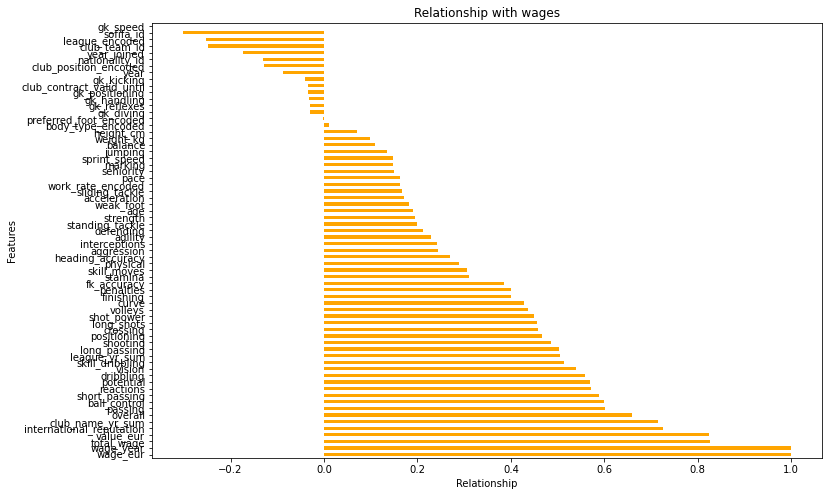

In [8]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [9]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.tail(60)

                           wage_eur
overall                    0.659235
passing                    0.601636
ball_control               0.599633
short_passing              0.588732
reactions                  0.571621
potential                  0.568485
dribbling                  0.558698
vision                     0.538980
skill_dribbling            0.514417
league_yr_sum              0.504871
long_passing               0.503237
shooting                   0.485837
positioning                0.466564
crossing                   0.458022
long_shots                 0.455191
shot_power                 0.448695
volleys                    0.437180
curve                      0.427801
finishing                  0.400920
penalties                  0.399453
fk_accuracy                0.384329
stamina                    0.311294
skill_moves                0.305084
physical                   0.288032
heading_accuracy           0.270455
aggression                 0.243305
interceptions              0

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



In [ ]:
'overall', 'passing', 'ball_control', 'short_passing', 'reactions', 'potential',
'dribbling', 'vision', 'skill_dribbling', 'league_yr_sum', 'long_passing', 'shooting'

In [ ]:
# identifying mvp columns
mvp = ['potential', 'reactions', 'vision', 'short_passing','long_passing',
                    'ball_control', 'curve', 'shot_power', 'volleys', 'long_shots',
                    'fk_accuracy', 'crossing', 'skill_dribbling']

In [ ]:
X_train = train[mvp]
y_train = train['wage_eur']

X_validate = validate[mvp]
y_validate = validate['wage_eur']

X_test = test[mvp]
y_test = test['wage_eur']

# Scaling

In [ ]:
scaler = RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#scaler, X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test, return_scaler=True)

# RMSE

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
# 1. Predict price_pred_mean
wage_eur_pred_mean = y_train.wage_eur.mean()
# creating a wage_eur_pred_mean column for my y_train
y_train['wage_eur_pred_mean'] = y_train.wage_eur.mean()
# creating a wage_eur_pred_mean column for my y_validate
y_validate['wage_eur_pred_mean'] = y_validate.wage_eur.mean()
# 2. compute price_pred_median
# creating a predictive median for y train 
y_train['wage_eur_pred_median'] = y_train.wage_eur.median()
# creating a predictive median for y_validate
y_validate['wage_eur_pred_median'] = y_validate.wage_eur.median()
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
# 4. RMSE of wage_eur_pred_median
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
y_test = pd.DataFrame(y_test)

y_test

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

In [ ]:
#residuals
y_train['lm_residuals'] = y_train['wage_eur_pred_lm'] - y_train['wage_eur']
y_validate['lm_residuals'] = y_validate['wage_eur_pred_lm'] - y_validate['wage_eur']

# LassoLars(lars)

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lars)**(1/2)

# predict validate
y_validate['wage_eur_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

In [ ]:
#residuals
y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']

# Twedie Regression Model (GLM)

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_glm)**(1/2)

# predict validate
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

In [ ]:
#residuals
y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']

# Polynomial Regression

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm2)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
#residuals
y_train['poly_residuals'] = y_train['wage_eur_pred_lm2'] - y_train['wage_eur']
y_validate['poly_residuals'] = y_validate['wage_eur_pred_lm2'] - y_validate['wage_eur']

# Evaluating Models

In [ ]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train_scaled)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

In [ ]:
df = pd.DataFrame(train[['potential', 'reactions', 'vision', 'short_passing','long_passing',
       'ball_control','wage_eur','yhat']])
df.head()

In [ ]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

In [ ]:
baseline

In [ ]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

In [ ]:
SSE = df['residual^2'].sum()
SSE_baseline = df['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

if SSE < SSE_baseline:
    print('SSE is better than baseline')
else:
    print('baseline is better')

In [ ]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

In [ ]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

In [ ]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

In [ ]:
# sklearn.metrics.explained_variance_score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(df.wage_eur, df.yhat)
print('Explained Variance = ', round(evs,3))

In [ ]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.wage_eur, df.yhat)

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(df.potential)
est = sm.OLS(df.wage_eur, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

def regression_errors(actual, predicted):
    return pd.Series({
                        'SSE': sse(actual, predicted),
                        'ESS': ess(actual, predicted),
                        'TSS': tss(actual),
                        'MSE': mse(actual, predicted),
                        'RMSE': rmse(actual, predicted),
                        })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
             'SSE': sse(actual, predicted),
             'MSE': mse(actual, predicted),
             'RMSE': rmse(actual, predicted),
            }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [ ]:
actual = y_train.wage_eur
predicted = df.yhat
residuals = actual - predicted

In [ ]:
def actual_vs_predicted():
    # plot to visualize actual vs predicted. 
    plt.figure(figsize=(16,8))
    plt.hist(y_validate.wage_eur, color='blue', alpha=.5, label="Actual Final wage_eur")
    plt.hist(y_validate.wage_eur_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
    plt.hist(y_validate.wage_eur_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
    plt.hist(y_validate.wage_eur_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
    plt.xlabel("Final wage(eur)")
    plt.ylabel("predicted wage_eur")
    plt.title("Comparing the Distribution of Actual wage_eur to Distributions of Predicted wage_eur for the Top Models")
    plt.legend()
    plt.show()
actual_vs_predicted()

In [ ]:
y_train

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)}, ignore_index=True)

In [ ]:
metric_df  

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LASSO'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_Poly'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_test}
""")



#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
sns.scatterplot(data = y_test)